In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(broom)
options(repr.matrix.max.rows=6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
telecom<-read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")|>
         select(tenure,MonthlyCharges,TotalCharges,Churn)|>
         filter(tenure!="NA")|>
         filter(MonthlyCharges!="NA")|>
         filter(TotalCharges!="NA")|>
         filter(Churn!="NA")|>
         mutate(Churn=as_factor(Churn))

telecom

Rows: 7043 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): customerID, gender, Partner, Dependents, PhoneService, MultipleLin...
dbl  (4): SeniorCitizen, tenure, MonthlyCharges, TotalCharges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
1,29.85,29.85,No
34,56.95,1889.50,No
2,53.85,108.15,Yes
⋮,⋮,⋮,⋮
11,29.60,346.45,No
4,74.40,306.60,Yes
66,105.65,6844.50,No


In [3]:
telecom_split<-initial_split(telecom,prop=0.75,class=Churn)
telecom_train<-training(telecom_split)
telecom_test<-testing(telecom_split)

In [4]:
library(caret)

upsample_telecom_train<-upSample(telecom_train,telecom_train$Churn)|>
                        select(-Churn)|>
                        rename(Churn=Class)

new_upsample_telecom_train<-tibble(upsample_telecom_train)

upsample_telecom_train

new_upsample_telecom_train

Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:purrr’:

    lift




tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
66,74.25,4859.25,No
48,19.95,1004.50,No
10,20.45,242.40,No
⋮,⋮,⋮,⋮
35,85.15,3030.60,Yes
2,85.70,169.80,Yes
8,105.50,829.55,Yes


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
66,74.25,4859.25,No
48,19.95,1004.50,No
10,20.45,242.40,No
⋮,⋮,⋮,⋮
35,85.15,3030.60,Yes
2,85.70,169.80,Yes
8,105.50,829.55,Yes


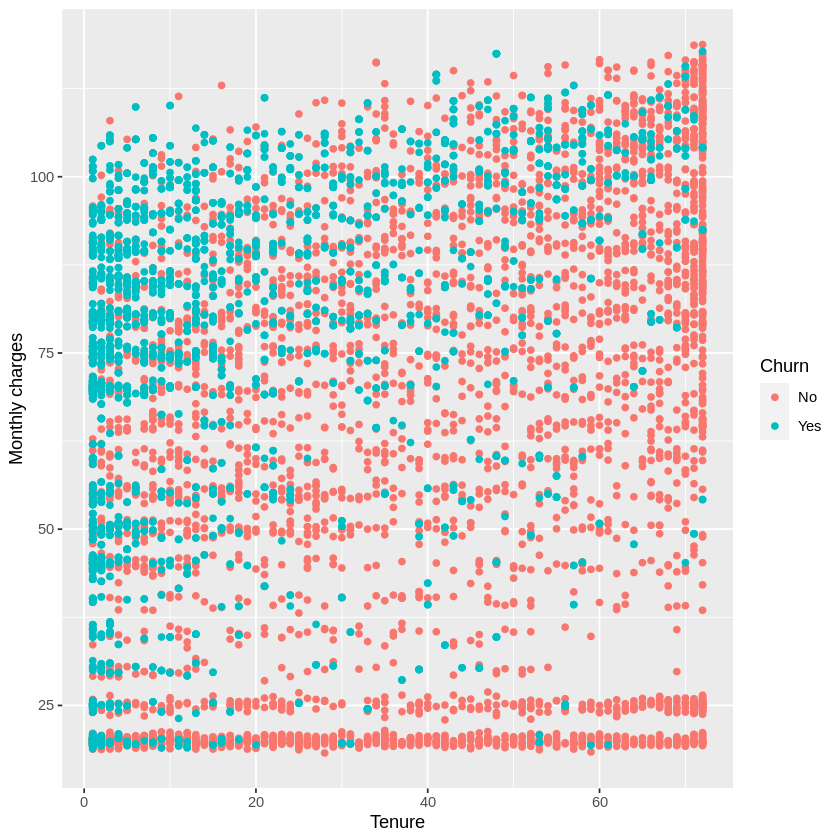

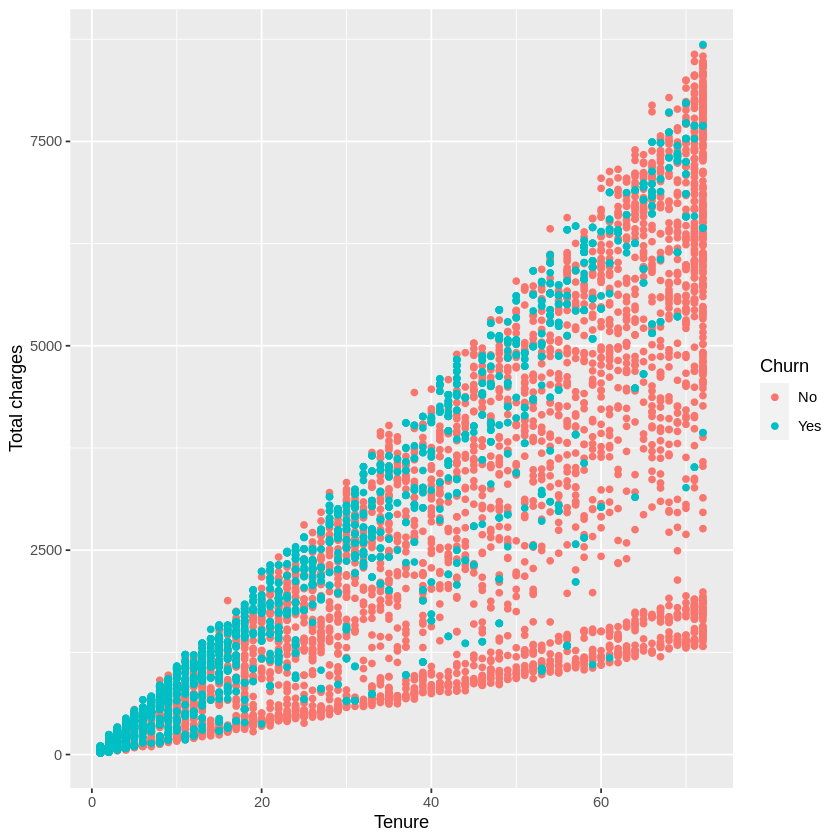

In [5]:
new_upsample_telecom_train_plot <- new_upsample_telecom_train |>
                                ggplot(aes(x=tenure, y = MonthlyCharges, color=Churn))+
                                geom_point()+
                                xlab("Tenure") +
                                ylab("Monthly charges")

new_upsample_telecom_train_plot 

new_upsample_telecom_train_plot2 <- new_upsample_telecom_train |>
                                ggplot(aes(x=tenure, y = TotalCharges, color=Churn))+
                                geom_point()+
                                xlab("Tenure") +
                                ylab("Total charges")
new_upsample_telecom_train_plot2



In [6]:
mean_tenure <- new_upsample_telecom_train |>    
               summarize(mean=mean(tenure))

mean_tenure

mean_monthly_charges <-  new_upsample_telecom_train |>    
                         summarize(mean=mean(MonthlyCharges))

mean_monthly_charges


mean_total_charges <-  new_upsample_telecom_train |>    
                         summarize(mean=mean(TotalCharges))

mean_total_charges



mean
<dbl>
27.99301


mean
<dbl>
67.79375


mean
<dbl>
2055.874


In [7]:
sd_tenure <- new_upsample_telecom_train |>    
               summarize(sd=sd(tenure))

sd_tenure

sd_monthly_charges <-  new_upsample_telecom_train |>    
                         summarize(sd=sd(MonthlyCharges))

sd_monthly_charges


sd_total_charges <-  new_upsample_telecom_train |>    
                         summarize(sd=sd(TotalCharges))

sd_total_charges



sd
<dbl>
24.0879


sd
<dbl>
28.8334


sd
<dbl>
2194.005


In [8]:
set.seed(1234)

knn_spec<-nearest_neighbor(weight_func="rectangular",neighbor=tune())|>
          set_engine("kknn")|>
          set_mode("classification")

telecom_recipe<-recipe(Churn~.,data=new_upsample_telecom_train)|>
                step_scale(all_predictors())|>
                step_center(all_predictors()) 

telecom_vfold<-vfold_cv(new_upsample_telecom_train,v=5,strata=Churn)

#kvals<-tibble(neighbors=seq(from=1,to=100,by=5))

telecom_workflow<-workflow()|>
                  add_recipe(telecom_recipe)|>
                  add_model(knn_spec)|>
                  tune_grid(resamples=telecom_vfold,grid=50)|>
                  collect_metrics()


telecom_workflow

filtered_telecom_metrics<-telecom_workflow|>
                         filter(.metric=="accuracy")

filtered_telecom_metrics


print(filtered_telecom_metrics)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8481699,5,0.005050402,Preprocessor1_Model01
1,roc_auc,binary,0.8481699,5,0.005050402,Preprocessor1_Model01
2,accuracy,binary,0.8480404,5,0.005050113,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.8289729,5,0.002936709,Preprocessor1_Model14
15,accuracy,binary,0.7488975,5,0.002144106,Preprocessor1_Model15
15,roc_auc,binary,0.8287107,5,0.003206781,Preprocessor1_Model15


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8481699,5,0.005050402,Preprocessor1_Model01
2,accuracy,binary,0.8480404,5,0.005050113,Preprocessor1_Model02
3,accuracy,binary,0.7833238,5,0.005578061,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,binary,0.7499348,5,0.002349740,Preprocessor1_Model13
14,accuracy,binary,0.7491581,5,0.002557151,Preprocessor1_Model14
15,accuracy,binary,0.7488975,5,0.002144106,Preprocessor1_Model15


# A tibble: 15 × 7
   neighbors .metric  .estimator  mean     n std_err .config              
       <int> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
 1         1 accuracy binary     0.848     5 0.00505 Preprocessor1_Model01
 2         2 accuracy binary     0.848     5 0.00505 Preprocessor1_Model02
 3         3 accuracy binary     0.783     5 0.00558 Preprocessor1_Model03
 4         4 accuracy binary     0.784     5 0.00582 Preprocessor1_Model04
 5         5 accuracy binary     0.758     5 0.00382 Preprocessor1_Model05
 6         6 accuracy binary     0.759     5 0.00358 Preprocessor1_Model06
 7         7 accuracy binary     0.751     5 0.00404 Preprocessor1_Model07
 8         8 accuracy binary     0.750     5 0.00404 Preprocessor1_Model08
 9         9 accuracy binary     0.747     5 0.00191 Preprocessor1_Model09
10        10 accuracy binary     0.747     5 0.00219 Preprocessor1_Model10
11        11 accuracy binary     0.748     5 0.00290 Preprocessor1_Model11
12    

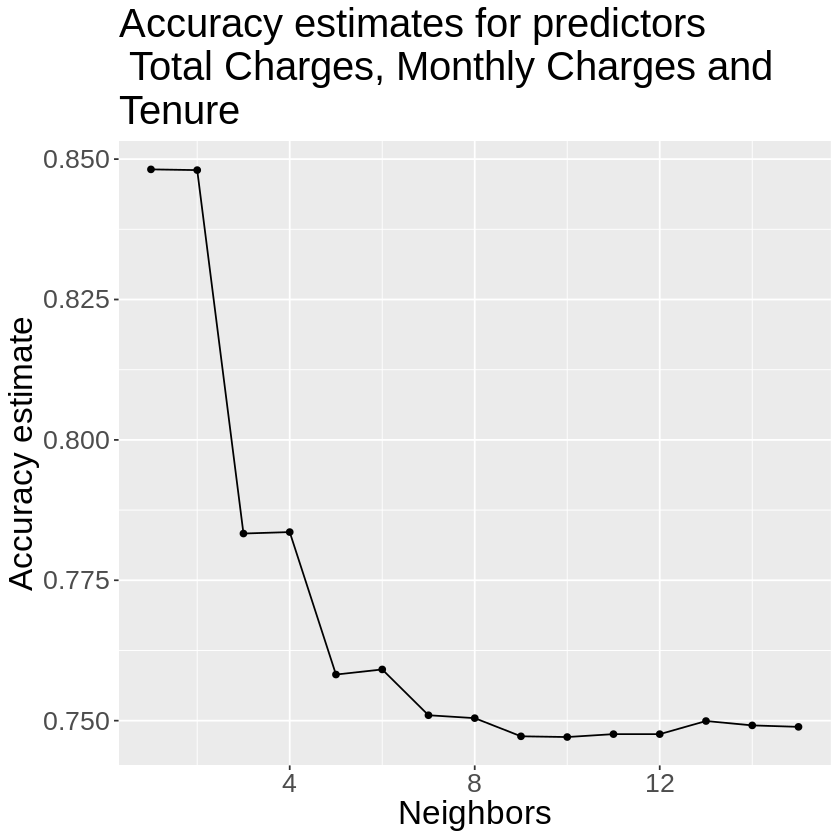

In [13]:
telecom_k_graph<-filtered_telecom_metrics|>
                 ggplot(aes(x=neighbors,y=mean))+
                 geom_point()+
                 geom_line()+
                 labs(x="Neighbors",y="Accuracy estimate")+
                 ggtitle("Accuracy estimates for predictors \n Total Charges, Monthly Charges and \nTenure")+
                 theme(text=element_text(size=20))

telecom_k_graph

In [10]:
#Therefore, the ideal predictor is one where the k-value=2 

knn_spec_1<-nearest_neighbor(weight_func="rectangular",neighbor=2)|>
          set_engine("kknn")|>
          set_mode("classification")

telecom_workflow_1<-workflow()|>
                    add_recipe(telecom_recipe)|>
                    add_model(knn_spec_1)|>
                    fit(new_upsample_telecom_train)
                             
telecom_test_predictions<-predict(telecom_workflow_1,telecom_test)|>
                          bind_cols(telecom_test)
                             
telecom_test_metrics<-telecom_test_predictions|>
                       metrics(truth=Churn,estimate=.pred_class)|>
                       filter(.metric=="accuracy")
                             
telecom_test_conf_mat<-telecom_test_predictions|>
                       conf_mat(truth=Churn,estimate=.pred_class)
                             
telecom_test_metrics
telecom_test_conf_mat
                  

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7098976


          Truth
Prediction   No  Yes
       No  1020  230
       Yes  280  228